***
**RCP216- INGÉNIERIE DE LA FOUILLE ET DE LA VISUALISATION DE DONNÉES MASSIVES**
<br> **PROJET : Notation automatique d'essais d'étudiants**

***

In [1]:
import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
# SparkConf().set("spark.driver.maxResultSize", "4g")
spark = SparkSession.builder.appName('Automated Essay Scoring data')\
    .config("spark.driver.maxResultSize", "4g")\
    .config("spark.memory.fraction", "1")\
    .config("spark.executor.memory", "2g")\
    .config("spark.driver.memory", "4g")\
    .getOrCreate()

22/02/06 20:37:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
# Import Spark NLP
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.pretrained import PretrainedPipeline
import sparknlp

In [94]:
app_data = spark.read.csv("asap-aes/training_set_rel3.tsv", sep=r'\t',header=True)
test_data = spark.read.csv("asap-aes/test_set.tsv",sep='\t', encoding='ISO-8859-1',header=True)
valid_data = spark.read.csv("asap-aes/valid_set.tsv",sep='\t', encoding='ISO-8859-1',header=True)

In [95]:
app_data.select(['essay_id', 'essay_set', 'essay', 'rater1_domain1', 'rater2_domain1','domain1_score']).show(5)

+--------+---------+--------------------+--------------+--------------+-------------+
|essay_id|essay_set|               essay|rater1_domain1|rater2_domain1|domain1_score|
+--------+---------+--------------------+--------------+--------------+-------------+
|       1|        1|Dear local newspa...|             4|             4|            8|
|       2|        1|Dear @CAPS1 @CAPS...|             5|             4|            9|
|       3|        1|Dear, @CAPS1 @CAP...|             4|             3|            7|
|       4|        1|"Dear Local Newsp...|             5|             5|           10|
|       5|        1|Dear @LOCATION1, ...|             4|             4|            8|
+--------+---------+--------------------+--------------+--------------+-------------+
only showing top 5 rows



In [6]:
test_data.show(5)

+--------+---------+--------------------+--------------------+--------------------+
|essay_id|essay_set|               essay|domain1_predictionid|domain2_predictionid|
+--------+---------+--------------------+--------------------+--------------------+
|    2383|        1|I believe that co...|                2383|                null|
|    2384|        1|"Dear @CAPS1, I k...|                2384|                null|
|    2385|        1|Dear to whom it @...|                2385|                null|
|    2386|        1|Dear @CAPS1 @CAPS...|                2386|                null|
|    2387|        1|Dear Local newspa...|                2387|                null|
+--------+---------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [7]:
valid_data.show(5)

+--------+---------+--------------------+--------------------+--------------------+
|essay_id|essay_set|               essay|domain1_predictionid|domain2_predictionid|
+--------+---------+--------------------+--------------------+--------------------+
|    1788|        1|"Dear @ORGANIZATI...|                1788|                null|
|    1789|        1|Dear @LOCATION1 T...|                1789|                null|
|    1790|        1|Dear Local newspa...|                1790|                null|
|    1791|        1|"Dear Readers, @C...|                1791|                null|
|    1792|        1|Dear newspaper, I...|                1792|                null|
+--------+---------+--------------------+--------------------+--------------------+
only showing top 5 rows



* **Supprimer les lignes dont toutes les valeurs sont nulles**

In [8]:
app_data = app_data.na.drop('all')
test_data = test_data.na.drop('all')
valid_data = valid_data.na.drop('all')

# 1. Description des données

* **Schema ddes données (Liste des colonnes et leur type)**

In [9]:
app_data.printSchema()

root
 |-- essay_id: string (nullable = true)
 |-- essay_set: string (nullable = true)
 |-- essay: string (nullable = true)
 |-- rater1_domain1: string (nullable = true)
 |-- rater2_domain1: string (nullable = true)
 |-- rater3_domain1: string (nullable = true)
 |-- domain1_score: string (nullable = true)
 |-- rater1_domain2: string (nullable = true)
 |-- rater2_domain2: string (nullable = true)
 |-- domain2_score: string (nullable = true)
 |-- rater1_trait1: string (nullable = true)
 |-- rater1_trait2: string (nullable = true)
 |-- rater1_trait3: string (nullable = true)
 |-- rater1_trait4: string (nullable = true)
 |-- rater1_trait5: string (nullable = true)
 |-- rater1_trait6: string (nullable = true)
 |-- rater2_trait1: string (nullable = true)
 |-- rater2_trait2: string (nullable = true)
 |-- rater2_trait3: string (nullable = true)
 |-- rater2_trait4: string (nullable = true)
 |-- rater2_trait5: string (nullable = true)
 |-- rater2_trait6: string (nullable = true)
 |-- rater3_trait

In [10]:
test_data.printSchema()

root
 |-- essay_id: string (nullable = true)
 |-- essay_set: string (nullable = true)
 |-- essay: string (nullable = true)
 |-- domain1_predictionid: string (nullable = true)
 |-- domain2_predictionid: string (nullable = true)



In [11]:
valid_data.printSchema()

root
 |-- essay_id: string (nullable = true)
 |-- essay_set: string (nullable = true)
 |-- essay: string (nullable = true)
 |-- domain1_predictionid: string (nullable = true)
 |-- domain2_predictionid: string (nullable = true)



* **Liste des colonnes**

In [12]:
print('Dataset columns: ',app_data.columns)

Dataset columns:  ['essay_id', 'essay_set', 'essay', 'rater1_domain1', 'rater2_domain1', 'rater3_domain1', 'domain1_score', 'rater1_domain2', 'rater2_domain2', 'domain2_score', 'rater1_trait1', 'rater1_trait2', 'rater1_trait3', 'rater1_trait4', 'rater1_trait5', 'rater1_trait6', 'rater2_trait1', 'rater2_trait2', 'rater2_trait3', 'rater2_trait4', 'rater2_trait5', 'rater2_trait6', 'rater3_trait1', 'rater3_trait2', 'rater3_trait3', 'rater3_trait4', 'rater3_trait5', 'rater3_trait6']


In [13]:
print("Nombre ligne données d'apprentissage: ",app_data.count())
print('Nombre ligne données de test: ', test_data.count())
print('Nombre ligne données de validation', valid_data.count())

22/02/06 20:37:47 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Nombre ligne données d'apprentissage:  12978
Nombre ligne données de test:  4254
Nombre ligne données de validation 4218


* **Calcul des valeurs nulles**

In [14]:
import pyspark.sql.functions as F
from functools import reduce

app_data_agg = app_data.agg(*[F.count(F.when(F.isnull(c), c)).alias(c) for c in app_data.columns])

app_data_agg_col = reduce(
    lambda a, b: a.union(b),
    (
        app_data_agg.select(F.lit(c).alias("Colonne"), F.col(c).alias("Valeurs_nulles_comptees")) 
        for c in app_data_agg.columns
    )
)

app_data_agg_col.withColumn("% de valeurs nulles", 
                            app_data_agg_col.Valeurs_nulles_comptees* 100/app_data.count()).show()

+--------------+-----------------------+--------------------+
|       Colonne|Valeurs_nulles_comptees| % de valeurs nulles|
+--------------+-----------------------+--------------------+
|      essay_id|                      0|                 0.0|
|     essay_set|                      0|                 0.0|
|         essay|                      0|                 0.0|
|rater1_domain1|                      2|0.015410695022345508|
|rater2_domain1|                      2|0.015410695022345508|
|rater3_domain1|                  12850|   99.01371551856988|
| domain1_score|                      2|0.015410695022345508|
|rater1_domain2|                  11179|   86.13807982740022|
|rater2_domain2|                  11179|   86.13807982740022|
| domain2_score|                  11179|   86.13807982740022|
| rater1_trait1|                  10686|   82.33934350439205|
| rater1_trait2|                  10686|   82.33934350439205|
| rater1_trait3|                  10686|   82.33934350439205|
| rater1

**Étant donné qu'une grande partie de l'ensemble de données contient des colonnes avec plus de 70 à 80 % de valeurs manquantes, nous allons supprimer ces colonnes et appliquer une méthodes d'imputation sur les colonnes rater1_domain1, rater2_domain1, domain1_score qui n'ont respectivement que 2 valeurs nulles**

1. **Suppression des colonnes avec plus de 2 valeurs nulles**

In [15]:
def drop_null_columns_spark(df, threshold=2):
    """
    Cette fonction supprime toutes les colonnes contenant des valeurs nulles avec un seuil.
     :param df : un cadre de données PySpark
     :param threshold : nombre minimum de valeurs nulles pour envisager la suppression de la colonne
    """
    null_counts = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).collect()[0].asDict()
    to_drop = [k for k, v in null_counts.items() if v > threshold]
    df = df.drop(*to_drop)
    return df

In [16]:
app_data = drop_null_columns_spark(app_data)

In [17]:
app_data.columns

['essay_id',
 'essay_set',
 'essay',
 'rater1_domain1',
 'rater2_domain1',
 'domain1_score']

Après avoir supprimé l'ensemble des colonnes dont le nombre de valeurs nulles est supérieure à 2, nous obtenons les colonnes suivant:
 * essay
 * essay_id
 * essay_set
 * domain1_score
 * rater1_domain1
 * rater2_domain1

Un autre partie consistéra à utiliser une méthode d'imputation sur les valeurs manquantes. 

2. **Convertir les variables (colonnes) obtenues dans les types adéquats**

In [18]:
# Données d'apprentissage
app_data = app_data.withColumn("essay_id", app_data["essay_id"].cast('int'))
app_data = app_data.withColumn("essay_set", app_data["essay_set"].cast('int'))
app_data = app_data.withColumn("domain1_score", app_data["domain1_score"].cast('int'))
app_data = app_data.withColumn("rater1_domain1", app_data["rater1_domain1"].cast('int'))
app_data = app_data.withColumn("rater2_domain1", app_data["rater2_domain1"].cast('int'))

In [19]:
# Données de test
test_data = test_data.withColumn("essay_id", test_data["essay_id"].cast('int'))
test_data = test_data.withColumn("essay_set", test_data["essay_set"].cast('int'))
test_data = test_data.withColumn("domain1_predictionid", test_data["domain1_predictionid"].cast('int'))

In [20]:
app_data.printSchema()

root
 |-- essay_id: integer (nullable = true)
 |-- essay_set: integer (nullable = true)
 |-- essay: string (nullable = true)
 |-- rater1_domain1: integer (nullable = true)
 |-- rater2_domain1: integer (nullable = true)
 |-- domain1_score: integer (nullable = true)



In [21]:
essay = app_data.essay

**Au regard du nombre de valeurs, nous pensons que peu importe la méthode d'imputation choisie il est peu probable que cela un effet sur les données.**

<code>
essay = app_data.essay
from pyspark.ml.feature import Imputer
val_manq_cols_in = ['essay_id', 'essay_set', 'rater1_domain1', 'rater2_domain1','domain1_score']
imputer = Imputer()
imputer.setInputCols(val_manq_cols_in)
imputer.setOutputCols(val_manq_cols_in)
model1 = imputer.fit(app_data)
app_data = model1.transform(app_data)
app_data.withColumn("essay", essay) 
app_data.show(5)</code>

In [22]:
from pyspark.ml.feature import Imputer
val_manq_cols_in = ['essay_id', 'essay_set', 'rater1_domain1', 'rater2_domain1','domain1_score']
imputer = Imputer()
imputer.setInputCols(val_manq_cols_in)
imputer.setOutputCols(val_manq_cols_in)
model1 = imputer.fit(app_data)

In [23]:
model1.surrogateDF.show()

+------------------+------------------+----------------+-----------------+-----------------+
|          essay_id|         essay_set|  rater1_domain1|   rater2_domain1|    domain1_score|
+------------------+------------------+----------------+-----------------+-----------------+
|10295.432809369702|4.1794575435352135|4.12692663378545|4.137099260172627|6.800015413070284|
+------------------+------------------+----------------+-----------------+-----------------+



In [24]:
app_data = model1.transform(app_data)
app_data.withColumn("essay", essay) 
app_data.show(5)

+--------+---------+--------------------+--------------+--------------+-------------+
|essay_id|essay_set|               essay|rater1_domain1|rater2_domain1|domain1_score|
+--------+---------+--------------------+--------------+--------------+-------------+
|       1|        1|Dear local newspa...|             4|             4|            8|
|       2|        1|Dear @CAPS1 @CAPS...|             5|             4|            9|
|       3|        1|Dear, @CAPS1 @CAP...|             4|             3|            7|
|       4|        1|"Dear Local Newsp...|             5|             5|           10|
|       5|        1|Dear @LOCATION1, ...|             4|             4|            8|
+--------+---------+--------------------+--------------+--------------+-------------+
only showing top 5 rows



* **Résumé des données**

In [25]:
desc = app_data['essay_id', 'essay_set', 'rater1_domain1', 'rater2_domain1','domain1_score'].describe()
desc.show(5)

+-------+------------------+------------------+-----------------+-----------------+-----------------+
|summary|          essay_id|         essay_set|   rater1_domain1|   rater2_domain1|    domain1_score|
+-------+------------------+------------------+-----------------+-----------------+-----------------+
|  count|             12978|             12978|            12978|            12978|            12978|
|   mean|10295.432809369702|4.1794575435352135|4.126907073509015|4.137078132223763|6.799892125134844|
| stddev| 6308.588616381018|2.1367490475815814|4.212363635959182|4.264156040745929|8.970155580269244|
|    min|                 1|                 1|                0|                0|                0|
|    max|             21633|                 8|               30|               30|               60|
+-------+------------------+------------------+-----------------+-----------------+-----------------+



* **Fréquence des variables**

`Fréquence des choix des essais`

In [190]:
app_data.groupBy('rater1_domain1').count().show(truncate=False)

+--------------+-----+
|rater1_domain1|count|
+--------------+-----+
|7             |127  |
|15            |113  |
|11            |102  |
|3             |2788 |
|30            |3    |
|8             |420  |
|22            |14   |
|28            |1    |
|16            |46   |
|0             |463  |
|null          |2    |
|5             |704  |
|18            |73   |
|27            |2    |
|17            |74   |
|26            |1    |
|6             |266  |
|19            |30   |
|23            |19   |
|25            |27   |
+--------------+-----+
only showing top 20 rows



In [26]:
app_data.groupBy('essay_set').count().show()

+---------+-----+
|essay_set|count|
+---------+-----+
|        1| 1783|
|        6| 1800|
|        3| 1726|
|        5| 1805|
|        4| 1772|
|        8|  723|
|        7| 1569|
|        2| 1800|
+---------+-----+



 1. Il y a beaucoup de valeurs nulles (plus de 80 % dans la plupart des colonnes). Il faudra appliquer un traitement pour les données manquantes 
 2. Il existe de nombreuses colonnes, dont la plupart peuvent ne pas contribuer à la performance de la formation d'un système
 3. Les choix des essaie sont inégalement réparties, de 500+ à 1500+

`Fréquences des notes données par l'examinateur 1`

In [27]:
app_data.groupBy('rater1_domain1').count().show()

+--------------+-----+
|rater1_domain1|count|
+--------------+-----+
|            28|    1|
|            27|    2|
|            26|    1|
|            12|  182|
|            22|   14|
|             1| 2062|
|            13|   13|
|             6|  266|
|            16|   46|
|             3| 2788|
|            20|  245|
|             5|  704|
|            19|   30|
|            15|  113|
|             9|  206|
|            17|   74|
|             4| 2256|
|             8|  420|
|            23|   19|
|             7|  127|
+--------------+-----+
only showing top 20 rows



# 2. DISTRIBUTION

In [28]:
# Pour la visulaisation
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import iplot
import matplotlib.pyplot as plt
import math

In [29]:
df = app_data.select("*")

* **Distribution des scores**

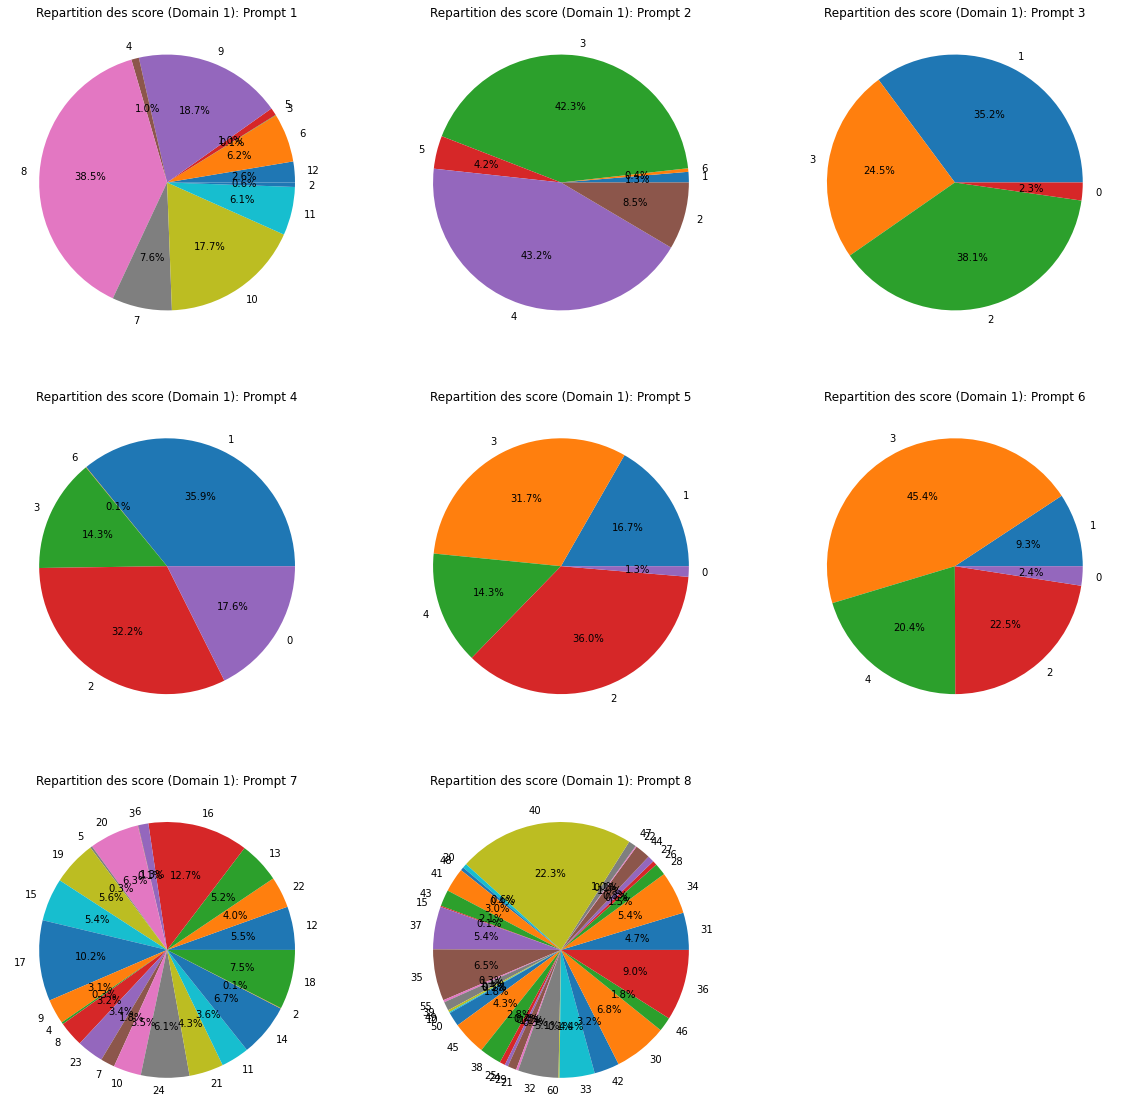

In [30]:
fig = plt.figure(figsize=(20,20))
for prompt in range(0,8):
    curdf = df[df['essay_set']==prompt+1]
    labels = []
    sizes = []
    curdf_count = curdf.groupBy('domain1_score').count().collect()
    for x, y in curdf_count:
        labels.append(x)
        sizes.append(y)
    ax1 = plt.subplot2grid((3,3),(math.floor((prompt)/3),math.floor((prompt)%3)))
    plt.pie(sizes,labels=labels,autopct='%1.1f%%')
    plt.title('Repartition des score (Domain 1): Prompt '+str(prompt+1))
plt.savefig('repartition_score.png')
plt.show()
#plt.savefig('repartition_score.png')

A partir de ces diagrammes, nous remarquons que:
  * La distribution des notes au sein d'un ensemble de dissertations est inégale
  * L'éventail des notes (c'est-à-dire la note minimale et maximale atteignable) pour chaque invite (Prompt) est très variable

* **Pourcentage des différents ensembles d'essais**

In [80]:
bels= df.groupBy('essay_set').count().select('essay_set').collect()#[0].essay_set
labels = [labels[i] for i in range(0,len(labels))]

In [84]:
labels= df.groupBy('essay_set').count().select('essay_set').collect()
labels = [labels[i] for i in range(0,len(labels))]
values = df.groupBy('essay_set').count().select('count').collect()
values = [values[cpt].asDict()['count'] for cpt in range(0, len(values))]

colors = df.select('essay_set').collect()#df['essay_set']
colors = [colors[0].essay_set for cpt in range(0, df.count())]
fig = go.Figure(data = [go.Pie(labels = labels, values = values, textinfo = "label+percent",
                              marker = dict(colors = colors, line=dict(color='#000000', width=0)), 
                              title = "Distribution des ensembles d'essais")])
fig.write_image("fig1.png")
fig.show()

**On peut voir sur le camambert que l'essais 5 a été le moins choisi pas les étudaints**

* **Effet de la longueur des phrases dans les essais sur les scores**

# 3. DATA PROCESSING

* Nettoyage de text

In [34]:
import re
import string
from string import punctuation
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [35]:
essay_list = list(
    app_data.select("essay").toPandas()["essay"]
)

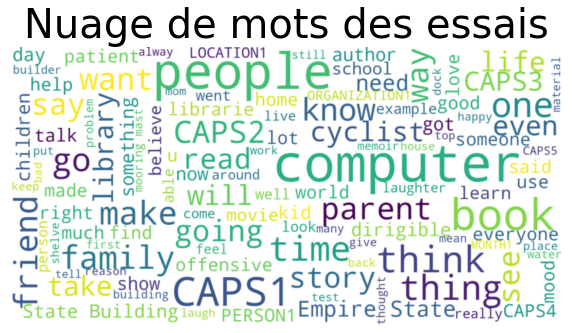

In [36]:
from wordcloud import WordCloud
word_cloud = WordCloud(
                       width=1600,
                       height=800, 
                       margin=0,
                       max_words=500, # Le nombre de mots qu'on veut voir 
                       max_font_size=150, min_font_size=30,
                       background_color="white"
            ).generate(" ".join(essay_list))

plt.figure(figsize=(10, 16))
plt.imshow(word_cloud, interpolation="gaussian")
plt.title('Nuage de mots des essais', fontsize = 40)
plt.axis("off")
plt.savefig("wordcloud.png", dpi=199)
plt.show()

In [37]:
essaytolist = app_data.select('essay').collect()
essays = [clean_text(essaytolist[cpt].essay) for cpt in range(0, len(essaytolist))]

In [38]:
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf

In [39]:
essay_udf = udf(clean_text, StringType())
app_data = app_data.withColumn('essay', essay_udf('essay'))

In [40]:
app_data.show(5)

+--------+---------+--------------------+--------------+--------------+-------------+
|essay_id|essay_set|               essay|rater1_domain1|rater2_domain1|domain1_score|
+--------+---------+--------------------+--------------+--------------+-------------+
|       1|        1|dear local newspa...|             4|             4|            8|
|       2|        1|dear   i believe ...|             5|             4|            9|
|       3|        1|dear    more and ...|             4|             3|            7|
|       4|        1|dear local newspa...|             5|             5|           10|
|       5|        1|dear  i know havi...|             4|             4|            8|
+--------+---------+--------------------+--------------+--------------+-------------+
only showing top 5 rows



In [41]:
essay_udf = udf(clean_text, StringType())
test_data = test_data.withColumn('essay', essay_udf('essay'))

* **Segmentation (Tokenization)**

In [45]:
from pyspark.ml.feature import Tokenizer
from nltk.corpus import wordnet, stopwords
from pyspark.ml.feature import StopWordsRemover

In [49]:
tokenizer = Tokenizer(outputCol="words")

In [50]:
# Données d'apprentissage
tokenizer.setInputCol("essay")
tokenizer.setOutputCol("tokens")
app_data_tokenize = tokenizer.transform(app_data)

In [51]:
test_data.show(5)

+--------+---------+--------------------+--------------------+--------------------+
|essay_id|essay_set|               essay|domain1_predictionid|domain2_predictionid|
+--------+---------+--------------------+--------------------+--------------------+
|    2383|        1|i believe that co...|                2383|                null|
|    2384|        1|dear  i know some...|                2384|                null|
|    2385|        1|dear to whom it  ...|                2385|                null|
|    2386|        1|dear    has come ...|                2386|                null|
|    2387|        1|dear local newspa...|                2387|                null|
+--------+---------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [86]:
# Données de test
tokenizer.setInputCol("essay")
tokenizer.setOutputCol("tokens")
test_data_tokenize = tokenizer.transform(test_data)
test_data_tokenize.show(5)

+--------+---------+--------------------+--------------------+--------------------+--------------------+
|essay_id|essay_set|               essay|domain1_predictionid|domain2_predictionid|              tokens|
+--------+---------+--------------------+--------------------+--------------------+--------------------+
|    2383|        1|i believe that co...|                2383|                null|[i, believe, that...|
|    2384|        1|dear  i know some...|                2384|                null|[dear, , i, know,...|
|    2385|        1|dear to whom it  ...|                2385|                null|[dear, to, whom, ...|
|    2386|        1|dear    has come ...|                2386|                null|[dear, , , , has,...|
|    2387|        1|dear local newspa...|                2387|                null|[dear, local, new...|
+--------+---------+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



* **Retrait des mots les plus fréquents (STOP WORDS)**

In [53]:
swen = stopwords.words('english')
remover = StopWordsRemover(stopWords=stopwords.words("english"))
remover.setInputCol("tokens")
remover.setOutputCol("words")

22/02/06 21:52:17 WARN StopWordsRemover: Default locale set was [fr_CI]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.


StopWordsRemover_913f4405970a

In [54]:
app_data_swr = remover.transform(app_data_tokenize)
test_data_swr = remover.transform(test_data_tokenize)

In [55]:
app_data_swr.columns, test_data_swr.columns

(['essay_id',
  'essay_set',
  'essay',
  'rater1_domain1',
  'rater2_domain1',
  'domain1_score',
  'tokens',
  'words'],
 ['essay_id',
  'essay_set',
  'essay',
  'domain1_predictionid',
  'domain2_predictionid',
  'tokens',
  'words'])

In [56]:
# words_list = app_data_swr.words

In [57]:
# drop_col = ["words","tokens"]
# app_data_swr.drop(*drop_col)

* **Stemming and Lemmatisation**

In [58]:
def combine_text(list_of_text):
    
    combined_text = ' '.join(list_of_text)
    return combined_text

In [59]:
essay_udf = udf(combine_text, StringType())
app_data_swr = app_data_swr.withColumn('words', essay_udf('words'))

In [60]:
app_data_swr.show(5)

Traceback (most recent call last):                                  (0 + 1) / 1]
  File "/Users/gnonguijacques/anaconda3/envs/sparkenv/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/Users/gnonguijacques/anaconda3/envs/sparkenv/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/Users/gnonguijacques/anaconda3/envs/sparkenv/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 643, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/Users/gnonguijacques/anaconda3/envs/sparkenv/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
EOFError


+--------+---------+--------------------+--------------+--------------+-------------+--------------------+--------------------+
|essay_id|essay_set|               essay|rater1_domain1|rater2_domain1|domain1_score|              tokens|               words|
+--------+---------+--------------------+--------------+--------------+-------------+--------------------+--------------------+
|       1|        1|dear local newspa...|             4|             4|            8|[dear, local, new...|dear local newspa...|
|       2|        1|dear   i believe ...|             5|             4|            9|[dear, , , i, bel...|dear   believe us...|
|       3|        1|dear    more and ...|             4|             3|            7|[dear, , , , more...|dear    people us...|
|       4|        1|dear local newspa...|             5|             5|           10|[dear, local, new...|dear local newspa...|
|       5|        1|dear  i know havi...|             4|             4|            8|[dear, , i, know,..

In [61]:
essay_udf = udf(combine_text, StringType())
test_data_swr = test_data_swr.withColumn('words', essay_udf('words'))

In [198]:
test_data_swr[['essay_set','essay','tokens','words']].show()

Traceback (most recent call last):                                  (0 + 1) / 1]
  File "/Users/gnonguijacques/anaconda3/envs/sparkenv/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/Users/gnonguijacques/anaconda3/envs/sparkenv/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/Users/gnonguijacques/anaconda3/envs/sparkenv/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 643, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/Users/gnonguijacques/anaconda3/envs/sparkenv/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
EOFError


+---------+--------------------+--------------------+--------------------+
|essay_set|               essay|              tokens|               words|
+---------+--------------------+--------------------+--------------------+
|        1|i believe that co...|[i, believe, that...|believe computers...|
|        1|dear  i know some...|[dear, , i, know,...|dear  know proble...|
|        1|dear to whom it  ...|[dear, to, whom, ...|dear  concern com...|
|        1|dear    has come ...|[dear, , , , has,...|dear    come atte...|
|        1|dear local newspa...|[dear, local, new...|dear local newspa...|
|        1|dear   is in my f...|[dear, , , is, in...|dear   firm belie...|
|        1|dear local newspa...|[dear, local, new...|dear local newspa...|
|        1|dear  i agreed wi...|[dear, , i, agree...|dear  agreed peop...|
|        1|dear   i do not b...|[dear, , , i, do,...|dear   believe co...|
|        1|imagine that you ...|[imagine, that, y...|imagine walk frie...|
|        1|dear people of

In [63]:
from pyspark.ml.feature import CountVectorizer

In [64]:
cv = CountVectorizer()
cv.setInputCol("tokens")
cv.setOutputCol("vectors")
#.show(truncate=False)

CountVectorizer_b262d8e11dd3

In [65]:
model = cv.fit(app_data_swr)
model.setInputCol("tokens")
app_vectors = model.transform(app_data_swr)

In [66]:
app_vectors.show(5)

+--------+---------+--------------------+--------------+--------------+-------------+--------------------+--------------------+--------------------+
|essay_id|essay_set|               essay|rater1_domain1|rater2_domain1|domain1_score|              tokens|               words|             vectors|
+--------+---------+--------------------+--------------+--------------+-------------+--------------------+--------------------+--------------------+
|       1|        1|dear local newspa...|             4|             4|            8|[dear, local, new...|dear local newspa...|(43833,[0,1,2,3,4...|
|       2|        1|dear   i believe ...|             5|             4|            9|[dear, , , i, bel...|dear   believe us...|(43833,[0,1,2,3,4...|
|       3|        1|dear    more and ...|             4|             3|            7|[dear, , , , more...|dear    people us...|(43833,[0,1,2,3,4...|
|       4|        1|dear local newspa...|             5|             5|           10|[dear, local, new...|

In [67]:
#model = cv.fit(test_data_swr)
model.setInputCol("tokens")
test_vectors = model.transform(test_data_swr)

In [68]:
app_vectors = app_vectors.drop('tokens')
app_vectors = app_vectors.drop('words')
test_vectors = test_vectors.drop('tokens')
test_vectors = test_vectors.drop('words')

In [69]:
app_vectors.show(5)

+--------+---------+--------------------+--------------+--------------+-------------+--------------------+
|essay_id|essay_set|               essay|rater1_domain1|rater2_domain1|domain1_score|             vectors|
+--------+---------+--------------------+--------------+--------------+-------------+--------------------+
|       1|        1|dear local newspa...|             4|             4|            8|(43833,[0,1,2,3,4...|
|       2|        1|dear   i believe ...|             5|             4|            9|(43833,[0,1,2,3,4...|
|       3|        1|dear    more and ...|             4|             3|            7|(43833,[0,1,2,3,4...|
|       4|        1|dear local newspa...|             5|             5|           10|(43833,[0,1,2,3,4...|
|       5|        1|dear  i know havi...|             4|             4|            8|(43833,[0,1,2,3,4...|
+--------+---------+--------------------+--------------+--------------+-------------+--------------------+
only showing top 5 rows



In [70]:
test_vectors.show(5)

+--------+---------+--------------------+--------------------+--------------------+--------------------+
|essay_id|essay_set|               essay|domain1_predictionid|domain2_predictionid|             vectors|
+--------+---------+--------------------+--------------------+--------------------+--------------------+
|    2383|        1|i believe that co...|                2383|                null|(43833,[0,1,2,3,4...|
|    2384|        1|dear  i know some...|                2384|                null|(43833,[0,1,2,3,4...|
|    2385|        1|dear to whom it  ...|                2385|                null|(43833,[0,1,2,3,4...|
|    2386|        1|dear    has come ...|                2386|                null|(43833,[0,1,2,3,4...|
|    2387|        1|dear local newspa...|                2387|                null|(43833,[0,1,2,3,4...|
+--------+---------+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [73]:
app_vectors.show(3)

+--------+---------+--------------------+--------------+--------------+-------------+--------------------+
|essay_id|essay_set|               essay|rater1_domain1|rater2_domain1|domain1_score|             vectors|
+--------+---------+--------------------+--------------+--------------+-------------+--------------------+
|       1|        1|dear local newspa...|             4|             4|            8|(43833,[0,1,2,3,4...|
|       2|        1|dear   i believe ...|             5|             4|            9|(43833,[0,1,2,3,4...|
|       3|        1|dear    more and ...|             4|             3|            7|(43833,[0,1,2,3,4...|
+--------+---------+--------------------+--------------+--------------+-------------+--------------------+
only showing top 3 rows



In [74]:
to_drop = ['essay_id','essay']
app_vectors = app_vectors.drop(*to_drop)

In [75]:
app_vectors.show(3)

+---------+--------------+--------------+-------------+--------------------+
|essay_set|rater1_domain1|rater2_domain1|domain1_score|             vectors|
+---------+--------------+--------------+-------------+--------------------+
|        1|             4|             4|            8|(43833,[0,1,2,3,4...|
|        1|             5|             4|            9|(43833,[0,1,2,3,4...|
|        1|             4|             3|            7|(43833,[0,1,2,3,4...|
+---------+--------------+--------------+-------------+--------------------+
only showing top 3 rows



# 3. MODELE FINAL

Nous allons nous d'abord implémenter les modèles basiques. Certains de ces modèles sont dans MLlib et d'autres non. Pour ces derniers, nous utiliserons la bibliothèques ScikitLearn

In [77]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit

In [78]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol='domain1_score', 
    predictionCol='prediction', 
    metricName='accuracy')

In [136]:
seed=1

models = ['LOGREG','RFC']

lr = LogisticRegression(labelCol='domain1_score',featuresCol='vectors')
rf = RandomForestClassifier(labelCol='domain1_score',featuresCol='vectors',seed=seed)

clfs = [lr,rf]

* **Division les données d'apprentissage en données de test et données et d'apprentissage**
<br> Le but ici est d'avoir un moyen d'évaluer l'éfficacité de notre modèle avant de le tester sur des données extérieures

In [137]:
(training_data, test_data) = app_vectors.randomSplit([0.8,0.2])

In [138]:
params = {
    models[0]: ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.fitIntercept, [False, True])\
    .addGrid(lr.elasticNetParam, [0.5, 0.8])\
    .addGrid(lr.maxIter, [2])\
    .build(),
    models[1]: ParamGridBuilder()\
    .addGrid(rf.numTrees, [5,50,100]) \
    .addGrid(dt.maxDepth, [5,8]) \
    .addGrid(rf.maxMemoryInMB, [2044]) \
    .addGrid(rf.impurity, ['gini'])\
    .build()
         }

In [139]:
y_test = 0
test_scores = []
for name, estimator in zip(models,clfs):
    print("Estimateur: ", name)
    tvs = CrossValidator(estimator=estimator,
                           estimatorParamMaps=params[name],
                           evaluator=evaluator,
                           numFolds=3)
    model = tvs.fit(training_data)
    predictions = model.transform(test_data)
    accuracy = evaluator.evaluate(predictions)
    test_scores.append((name,model,accuracy))

Estimateur:  LOGREG


22/02/07 02:02:34 WARN DAGScheduler: Broadcasting large task binary with size 1175.6 KiB
22/02/07 02:07:02 WARN DAGScheduler: Broadcasting large task binary with size 1164.9 KiB
22/02/07 02:08:09 WARN DAGScheduler: Broadcasting large task binary with size 1172.9 KiB
22/02/07 02:12:53 WARN DAGScheduler: Broadcasting large task binary with size 1165.5 KiB
22/02/07 02:13:53 WARN DAGScheduler: Broadcasting large task binary with size 1171.4 KiB
22/02/07 02:18:09 WARN DAGScheduler: Broadcasting large task binary with size 1169.1 KiB
22/02/07 02:19:04 WARN DAGScheduler: Broadcasting large task binary with size 1180.1 KiB
22/02/07 02:20:06 WARN DAGScheduler: Broadcasting large task binary with size 1225.5 KiB


Estimateur:  RFC


22/02/07 02:20:22 WARN DAGScheduler: Broadcasting large task binary with size 1664.9 KiB
22/02/07 02:20:26 WARN DAGScheduler: Broadcasting large task binary with size 1677.2 KiB
22/02/07 02:20:26 WARN DAGScheduler: Broadcasting large task binary with size 1700.0 KiB
22/02/07 02:20:27 WARN DAGScheduler: Broadcasting large task binary with size 1738.8 KiB
22/02/07 02:20:28 WARN DAGScheduler: Broadcasting large task binary with size 1805.1 KiB
22/02/07 02:20:52 WARN DAGScheduler: Broadcasting large task binary with size 1664.9 KiB
22/02/07 02:21:00 WARN DAGScheduler: Broadcasting large task binary with size 1677.2 KiB
22/02/07 02:21:01 WARN DAGScheduler: Broadcasting large task binary with size 1700.0 KiB
22/02/07 02:21:02 WARN DAGScheduler: Broadcasting large task binary with size 1738.8 KiB
22/02/07 02:21:03 WARN DAGScheduler: Broadcasting large task binary with size 1805.1 KiB
22/02/07 02:21:24 WARN DAGScheduler: Broadcasting large task binary with size 1705.1 KiB
22/02/07 02:21:29 WAR

22/02/07 02:32:06 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/02/07 02:32:11 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/02/07 02:32:17 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/02/07 02:32:38 WARN DAGScheduler: Broadcasting large task binary with size 1752.7 KiB
22/02/07 02:32:46 WARN DAGScheduler: Broadcasting large task binary with size 1991.6 KiB
22/02/07 02:32:49 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/02/07 02:32:54 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/02/07 02:32:59 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/02/07 02:33:06 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/02/07 02:34:20 WARN DAGScheduler: Broadcasting large task binary with size 1766.3 KiB
22/02/07 02:34:42 WARN DAGScheduler: Broadcasting large task binary with size 1886.0 KiB
22/02/07 02:34:45 WARN DAGScheduler: Broad

* Score en test regression logistique, forêts aléatoires

In [140]:
test_scores

[('LOGREG', CrossValidatorModel_93b22e2601cf, 0.3261538461538461),
 ('RFC', CrossValidatorModel_ef691e26332e, 0.32346153846153847)]

In [178]:
lrm = test_scores[0][1].bestModel
rfm = test_scores[1][1].bestModel

* Score en apprentissage regression logistique, forêts aléatoires

In [179]:
lrm.summary.accuracy, rfm.summary.accuracy

(0.43283869724417035, 0.3354210830603199)

* Paramètre du modèls de régression logistique

In [185]:
lrm._java_obj.getElasticNetParam(), lrm._java_obj.getRegParam()

(0.5, 0.01)

* Paramètre du modèls des forêts aléatoires

In [182]:
rfm._java_obj.getNumTrees(), rfm._java_obj.getMaxDepth()

(50, 5)

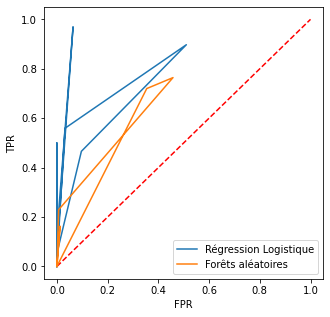

In [184]:
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(lrm.summary.falsePositiveRateByLabel,#roc.select('domain1_score').collect(),
         lrm.summary.truePositiveRateByLabel, label="Régression Logistique")#roc.select('probabilty').collect())
plt.plot(rfm.summary.falsePositiveRateByLabel,#roc.select('domain1_score').collect(),
         rfm.summary.truePositiveRateByLabel, label="Forêts aléatoires")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.savefig("roc.png")
plt.show()

In [199]:
#!pip freeze > requirements.txt